# IHLT Project


In [5]:
# Autoreload
%load_ext autoreload
%autoreload 2

import pandas as pd
import csv
import nltk

from utils.preprocessor import Preprocessor
from features.dummy_features import add_dummy_features
from features.statistical_features import add_POS_statistics

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('stopwords')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\paubl\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\paubl\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\paubl\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\paubl\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\paubl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Load data

In [6]:
TRAIN_PATH = '../data/train/01_raw/'
TRAIN_GS_PATH = '../data/train/scores/'
TEST_PATH = '../data/test/01_raw/'
TEST_GS_PATH = '../data/test/scores/'

def load_data(path_f, path_gs, files):
    # Read first file
    dt = pd.read_csv(path_f + 'STS.input.' + files[0] + '.txt', sep='\t', quoting=csv.QUOTE_NONE, header=None, names=['s1', 's2'])
    dt['gs'] = pd.read_csv(path_gs + 'STS.gs.' + files[0] + '.txt', sep='\t', header=None, names=['gs'])
    # Concatenate the rest of files
    for f in files[1:]:
        dt2 = pd.read_csv(path_f + 'STS.input.' + f + '.txt', sep='\t', quoting=csv.QUOTE_NONE, header=None, names=['s1', 's2'])
        dt2['gs'] = pd.read_csv(path_gs + 'STS.gs.' + f + '.txt', sep='\t', header=None, names=['gs'])
        dt = pd.concat([dt, dt2], ignore_index=True)
    return dt

## Create models

In [18]:
def train_NN(df, input, output):
    X = df[input]
    y = df[output]
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)
    model = Sequential()
    model.add(Dense(10, input_dim=len(input), activation='relu'))
    model.add(Dense(5, activation='relu'))               
    model.add(Dense(1))                                   
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32)
    return history, model


In [8]:
def plot_history(history):
    import matplotlib.pyplot as plt
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('model mae')
    plt.ylabel('mae')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

## Basic pipeline

### Train a model

(2234, 3)
Epoch 1/50


d:\projects\MAI\IHLT\Intro-to-IHLT-Labs\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 14.3710 - mae: 3.3999 - val_loss: 8.2419 - val_mae: 2.5560
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.0209 - mae: 2.3616 - val_loss: 6.1124 - val_mae: 2.1289
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.6019 - mae: 2.0500 - val_loss: 4.6379 - val_mae: 1.8110
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.6302 - mae: 1.8027 - val_loss: 3.8101 - val_mae: 1.6656
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.3491 - mae: 1.5985 - val_loss: 3.6830 - val_mae: 1.6324
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.2139 - mae: 1.4555 - val_loss: 3.0729 - val_mae: 1.4988
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8283 - mae: 1.3893 - val_loss: 2.6173 - val_mae: 1.3678
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.4769 - mae: 1.3152 - val_loss: 2.3686 - val_mae: 1.2933
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.2759 - mae: 1.2494 - v

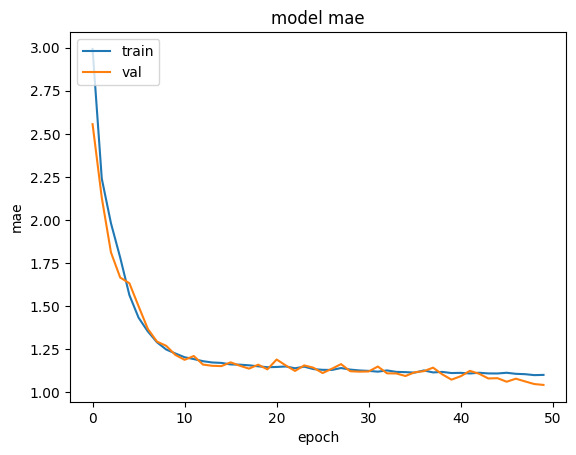

In [21]:
# Create the desired features
def add_features(dt):
    add_dummy_features(dt)
    add_POS_statistics(dt)

# Load train data
all_train_files = ['SMTeuroparl', 'MSRvid', 'MSRpar']
df = load_data(TRAIN_PATH, TRAIN_GS_PATH, all_train_files)
print(df.shape)
df.tail(5)

# Sample of preprocessing
# prep = Preprocessor()
# lemmas = prep.preprocess_df(df, 'semantic')
# print(len(lemmas))
# print(lemmas[:5])

# Add features to the train data
add_features(df)

# Features to use in the model
features = ['dif_len', 'dif_words', 'dif_n_words', 'dif_n_verbs', 'dif_n_nouns', 'dif_n_adjectives', 'dif_n_adverbs']
# Train the model
hist, model = train_NN(df, features, 'gs')
plot_history(hist)


## Compute correlation of the model

In [22]:
from scipy.stats import pearsonr

# Load test data
# Doubt: The files with the same name are the same files as in the training set? If so, we have to use them also for testing?
all_test_files = ['SMTeuroparl', 'MSRvid', 'MSRpar', 'surprise.OnWN', 'surprise.SMTnews']
df_test = load_data(TEST_PATH, TEST_GS_PATH, all_test_files)

# Add the features to the test data
add_features(df_test)
# Fill column of the dataset with the predictions of the model
df_test['predicted'] = model.predict(df_test[features])

# Compute the Pearson correlation between the predictions and the gold standard
corr = pearsonr(df_test['gs'], df_test['predicted'])[0]
print('Pearson correlation:', corr)


98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Pearson correlation: 0.006960255264242654
